# 빅데이터분석 프로젝트 A2박성건

# 1. 과제 정의
## 다양한 예측 모델을 활용하여 목표변수인 주택가격에 영향을 주는 인자를 도출하기

타겟 변수: 주택가격(중앙값)


CRIM: 1인당 범죄율 

ZN: 주거지 비율(25000 F^2 초과)

INDUS: 비주거 상업지역 비율

CHAS: 강조망(1-조망, 0-비조망)

NOX: 산화질소 농도

RM: 가구당 평균 방 수

AGE: 자기 소유 집 비율(1940년 이전)

DIS: 중심지(직업센터)접근 거리

RAD: 방사형 도로 접근성 지수

TAX: 재산세율($10,00)당

PTRATIO: 학생/교사 비율

B: 흑인 인구 비율
1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT: 저소득층 비율(%) 

주택가격에 영향을 가장 많이 끼치는 요소를 분석하여
이유를 분석해보고 새로운 요인들과 결합하여 생각해보기

# 2. 가설정의
1. 흑인 비율에 따라 주택가격이 차이가 있을까?
2. 노후 건물 비율이 높으면 주택가격이 낮을것이다.
4. 주거당 평균 객실 수가 많으면 주택가격이 높을것이다.
5. 주거지 비율이 높을수록 주택가격이 비쌀것이다.
6. 중심지 접근 거리가 가까울수록 주택가격이 비쌀것이다.
7. 범죄율이 높으면 주택가격이 저렴할 것이다.
8. 저소득층 비율이 낮으면 주택가격이 비쌀것이다.

# 3. 분석계획

1. 탐색적 기법 사용하여 그래픽적으로 변수들의 형태와 이상치등을 파악,제거
2. 상관 분석을 통해 다중공선성이 높은 요소를 제거하고 후진 제거법으로 유의미한 영향을 미치지 않는 요소 제거
3. 모델링 기법 중 회귀분석을 통해 각 요소와 타겟변수의 회귀식 도출
4. 결정트리와 랜덤포레스트, 그래디언트 부스팅을 통해 예측 모델링 

# 4. 데이터처리

In [117]:
#사용할 라이브러리 포함
import pandas as pd
import numpy as np


import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from sklearn.preprocessing import scale, minmax_scale, robust_scale
import matplotlib.font_manager as fm
from statsmodels.stats.stattools import omni_normtest
from statsmodels.api import qqplot,add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz


In [118]:
#글꼴 설정
%matplotlib inline
matplotlib.rc('font', family='NanumGothic')
plt.rc('font', family ='NanumGothic')
plt.rcParams["axes.unicode_minus"] = False

In [119]:
#데이터불러오기
df_raw = pd.read_csv("/home/piai/bigdata/data/BigData/BOSTON_HOUSING.csv", engine='python',encoding='cp949')
df_raw.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


In [120]:
df_raw.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063
std,9.197104,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000
50%,21.200001,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000
75%,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999
max,50.000000,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001


In [121]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MEDV     506 non-null    float64
 1   CRIM     506 non-null    float64
 2   ZN       506 non-null    float64
 3   INDUS    506 non-null    float64
 4   CHAS     506 non-null    int64  
 5   NOX      506 non-null    float64
 6   RM       506 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      506 non-null    float64
 9   RAD      506 non-null    int64  
 10  TAX      506 non-null    int64  
 11  PTRATIO  506 non-null    float64
 12  B        506 non-null    float64
 13  LSTAT    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


요소제거
흑인의 비율인 B는 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
이렇게 표현되어 있는데 Bk가 0.9일 때와 Bk가 0.36 일 때의 B값은 79.2로 동일하게 된다.
하지만 79.2라는 B값을 가지고 있을 때 Bk가 0.9인지 0.36인지 판단한 수 있는 충분한 근거가 존재하지 않는다고 생각한다. 따라서 B는 흑인이 차지하는 비율을 말하지 못하고 작을 수록 63퍼와 가깝고 63프로의 비율과 멀어질 수록 값이 크다.

In [122]:
df_raw=df_raw.drop(["B"],axis=1)

In [123]:
#결측치 확인
df_raw.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
dtype: int64

정규화를 하여 박스 플롯을 그려 이상치확인

<AxesSubplot:>

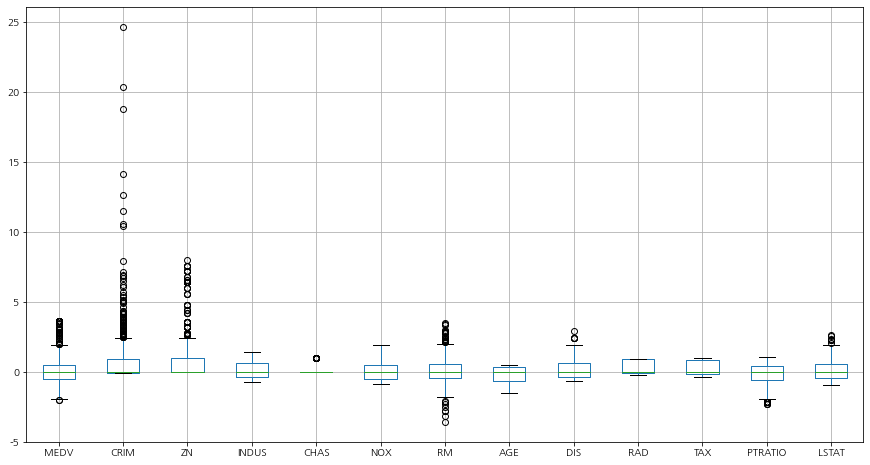

In [124]:
#데이터셋을 표준화 한후 박스그래프를 그려 이상치를 확인해본다.
df_scaled=robust_scale(df_raw)
df_scaled=pd.DataFrame(df_scaled,columns=df_raw.columns)
df_scaled.boxplot(figsize=(15,8))

In [125]:
# 이상치 제거
# CRIM, ZN, 은 이상치가 많음으로 제거해준다.

df_scaled = df_scaled[df_scaled["CRIM"]<5]
df_scaled = df_scaled[df_scaled["ZN"]<5]

In [126]:
df_scaled.describe() # 이상치가 제거된 데이터셋의 decribe

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,0.157659,0.600918,0.506667,0.138871,0.075556,0.128565,0.100882,-0.143156,0.133547,0.218333,0.192690,-0.188175,0.126872
std,1.091254,1.120225,1.066127,0.517511,0.264580,0.642781,0.893938,0.545463,0.602526,0.424923,0.429389,0.748079,0.660044
min,-1.868339,-0.069593,0.000000,-0.653757,0.000000,-0.851428,-3.587399,-1.520897,-0.672824,-0.200000,-0.366925,-2.160713,-0.962519
25%,-0.498433,-0.045430,0.000000,-0.296669,0.000000,-0.422857,-0.428862,-0.536188,-0.352311,-0.050000,-0.131783,-0.589286,-0.391804
50%,0.000000,0.008407,0.000000,0.016266,0.000000,0.000000,-0.021003,0.034658,-0.035036,0.000000,0.000000,0.017857,0.028486
75%,0.451410,0.734647,0.000000,0.651433,0.000000,0.491429,0.485095,0.337920,0.480555,0.150000,0.868217,0.410714,0.527236
max,3.611285,4.959083,4.800000,1.398141,1.000000,1.902857,3.484418,0.458716,2.429483,0.950000,0.984496,0.767857,2.339830


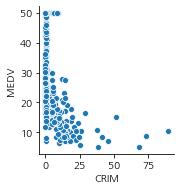

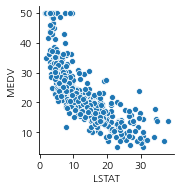

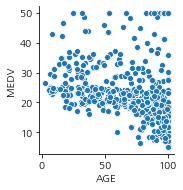

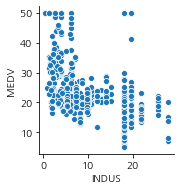

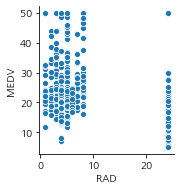

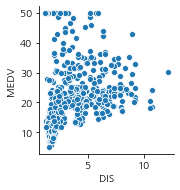

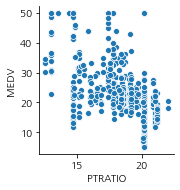

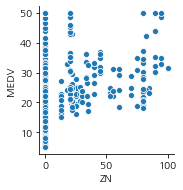

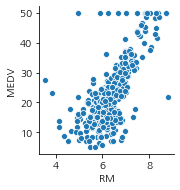

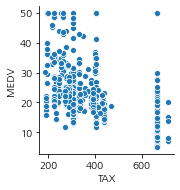

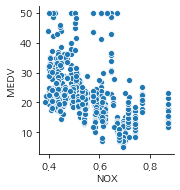

In [127]:
# pairplot 그려보기

ls = ["CRIM","LSTAT","AGE","INDUS","RAD","DIS","PTRATIO","ZN","RM","TAX","NOX"]

for i in ls:
    sns.pairplot(df_raw,y_vars="MEDV",x_vars=i)

<AxesSubplot:>

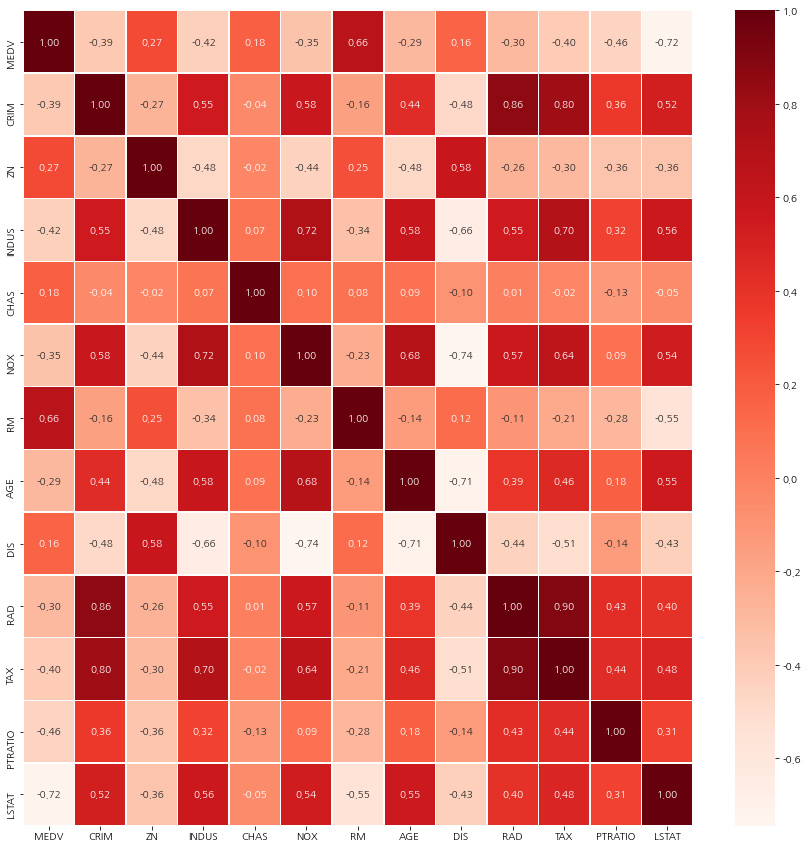

In [128]:
#히트맵
plt.figure(figsize=(15,15))
sns.heatmap(data = df_scaled.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Reds')

In [129]:
# #타겟변수와 설명변수를 나눈다.
# df_scaled_y=df_scaled['MEDV']
# df_scaled_x=df_scaled.drop("MEDV",axis=1,inplace=False)

In [130]:
# #데이터셋을 나눈다.
# df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_scaled_x,df_scaled_y,test_size=0.3,random_state=1234)
# print('train data X size:{}'.format(df_train_x.shape))
# print('train data Y size:{}'.format(df_train_y.shape))
# print('test data X size:{}'.format(df_test_x.shape))
# print('test data Y size:{}'.format(df_test_y.shape))

In [131]:
#데이터에 대한 정보 얻기
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MEDV     450 non-null    float64
 1   CRIM     450 non-null    float64
 2   ZN       450 non-null    float64
 3   INDUS    450 non-null    float64
 4   CHAS     450 non-null    float64
 5   NOX      450 non-null    float64
 6   RM       450 non-null    float64
 7   AGE      450 non-null    float64
 8   DIS      450 non-null    float64
 9   RAD      450 non-null    float64
 10  TAX      450 non-null    float64
 11  PTRATIO  450 non-null    float64
 12  LSTAT    450 non-null    float64
dtypes: float64(13)
memory usage: 49.2 KB


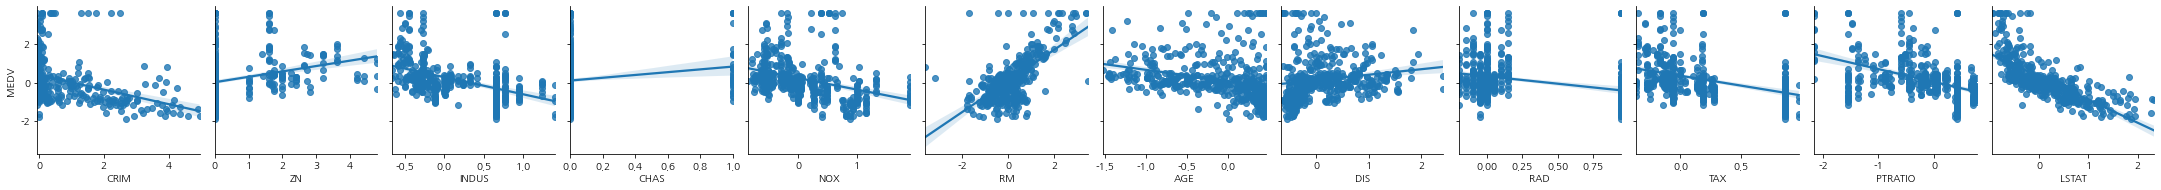

In [132]:
# pairplot을 통해 목표변수와 각 요소간의 경향성을 볼수있다.
sns.pairplot(df_scaled, y_vars="MEDV", x_vars = ["CRIM", "ZN", 'INDUS', "CHAS",'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT'],kind = 'reg')

In [133]:
df_scaled.corr().round(3)

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
MEDV,1.000,-0.386,0.274,-0.424,0.176,-0.355,0.663,-0.293,0.158,-0.300,-0.401,-0.458,-0.724
CRIM,-0.386,1.000,-0.270,0.546,-0.036,0.577,-0.160,0.436,-0.482,0.857,0.799,0.360,0.524
ZN,0.274,-0.270,1.000,-0.476,-0.022,-0.441,0.251,-0.476,0.583,-0.258,-0.299,-0.362,-0.363
INDUS,-0.424,0.546,-0.476,1.000,0.067,0.723,-0.336,0.578,-0.661,0.547,0.705,0.317,0.559
CHAS,0.176,-0.036,-0.022,0.067,1.000,0.098,0.085,0.092,-0.104,0.006,-0.022,-0.125,-0.050
NOX,-0.355,0.577,-0.441,0.723,0.098,1.000,-0.231,0.684,-0.745,0.566,0.644,0.088,0.540
RM,0.663,-0.160,0.251,-0.336,0.085,-0.231,1.000,-0.144,0.120,-0.110,-0.210,-0.285,-0.552
AGE,-0.293,0.436,-0.476,0.578,0.092,0.684,-0.144,1.000,-0.707,0.386,0.460,0.176,0.554
DIS,0.158,-0.482,0.583,-0.661,-0.104,-0.745,0.120,-0.707,1.000,-0.438,-0.511,-0.139,-0.431
RAD,-0.300,0.857,-0.258,0.547,0.006,0.566,-0.110,0.386,-0.438,1.000,0.903,0.432,0.404


집값과 가장 상관성이 낮은 요소는 CHAT 강 조망권이다.
강조망권이 1일때와 0일 때 집값을 비교해본다.

<AxesSubplot:>

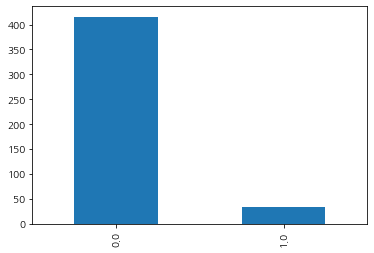

In [134]:
#강조망권이 1일때와 0일 때 수 비교
df_count = df_scaled["CHAS"].value_counts()
df_count.plot.bar()

강조망권이 0일 때와 1일때의 수는 상당히 많이 차이가 나는 것을 볼 수 있다.

<AxesSubplot:xlabel='CHAS', ylabel='MEDV'>

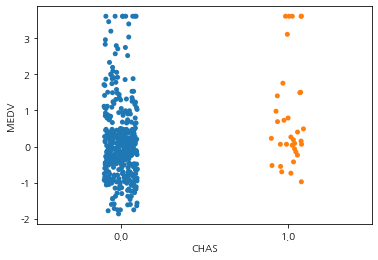

In [135]:
sns.stripplot(x='CHAS', y='MEDV', data=df_scaled)

<AxesSubplot:xlabel='CHAS', ylabel='MEDV'>

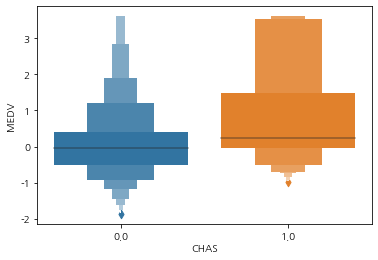

In [136]:
sns.boxenplot(x='CHAS', y='MEDV', data=df_scaled)

In [137]:
df_scaled['MEDV'].corr(df_scaled['CHAS'])

0.1758956942970651

강조망이 0 일 때와 강조망이 1 일때의 그래프를 분석해보면 1일 때 최저값과 평균 중앙값 모두 0일 때보다 높다고 볼수 있다. 다른 값이 모두 동일하다고 할 때 강조망은 집값에 영향을 줄 수 있다. 하지만 상관계수를 보면 0.175로 양의 상관계수를 가지고 있지만 많은 영향을 준다고 말하기 어렵다.

In [138]:
#타겟변수와 설명변수를 나눈다.
df_scaled_y=df_scaled['MEDV']
df_scaled_x=df_scaled.drop("MEDV",axis=1,inplace=False)

In [146]:
#데이터셋을 나눈다.
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_scaled_x,df_scaled_y,test_size=0.3,random_state=1234)
print('train data X size:{}'.format(df_train_x.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_x.shape))
print('test data Y size:{}'.format(df_test_y.shape))

train data X size:(315, 12)
train data Y size:(315,)
test data X size:(135, 12)
test data Y size:(135,)


In [147]:
#큰 다중공선성가진 요소를 확인해본다
df_scaled_x_const = add_constant(df_scaled_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_scaled_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_scaled_x_const.values,i) for i in range(df_scaled_x_const.shape[1])]

df_vif.sort_values("VIF",inplace=True)
df_vif.round(3)
#크게 높은 값을 가지는 요소가 없음으로 놔둔다.

,variable,VIF
4,CHAS,1.074
6,RM,1.720
11,PTRATIO,1.792
2,ZN,1.879
0,const,2.403
12,LSTAT,2.649
7,AGE,2.650
8,DIS,3.405
3,INDUS,3.505
5,NOX,3.953


In [148]:
rfe_reg_model = smf.ols(formula = "MEDV ~ CHAS + CRIM + RM + ZN + AGE + NOX + RAD + TAX + INDUS + DIS + PTRATIO + LSTAT", data = df_scaled)

rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     91.24
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          7.81e-111
Time:                        04:40:55   Log-Likelihood:                -395.09
No. Observations:                 450   AIC:                             816.2
Df Residuals:                     437   BIC:                             869.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2421      0.043      5.608      0.0

<AxesSubplot:>

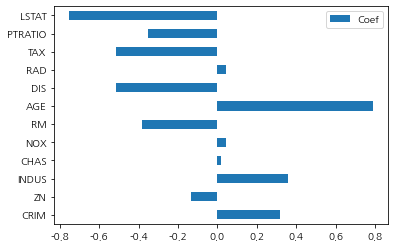

In [149]:
selected_cols = df_scaled_x.columns
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, \
                          index = selected_cols)

df_reg_coef.plot.barh(y="Coef",legend = True)

In [150]:
#후진 제거법
df_raw_y = df_raw["MEDV"]
model = LinearRegression()


rfe = RFE(estimator = model, n_features_to_select= 5).fit(df_scaled_x,df_scaled_y)



selected_cols = df_scaled_x.columns[rfe.support_]

removed_cols = df_scaled_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols))
print("Removed Variables: {}".format(removed_cols))


Selected Variables : Index(['CHAS', 'RM', 'DIS', 'TAX', 'LSTAT'], dtype='object')
Removed Variables: Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'AGE', 'RAD', 'PTRATIO'], dtype='object')


In [151]:
rfe_reg_model = smf.ols(formula = "MEDV ~ NOX + RM + DIS + PTRATIO + LSTAT", data = df_scaled)

rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     203.3
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          2.37e-112
Time:                        04:41:12   Log-Likelihood:                -409.44
No. Observations:                 450   AIC:                             830.9
Df Residuals:                     444   BIC:                             855.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2665      0.035      7.577      0.0

<AxesSubplot:>

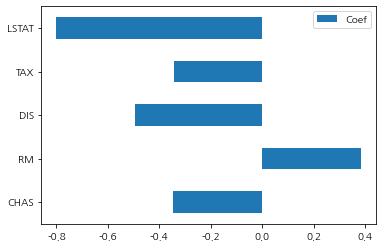

In [145]:
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, \
                          index = selected_cols)

df_reg_coef.plot.barh(y="Coef",legend = True)

# 의사결정나무

In [14]:
#변수명 저장
v_feature_name = df_raw.columns



scaler=StandardScaler()
df_scaled = scaler.fit_transform(df_raw)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.159686,-0.419782,0.284830,-1.287910,-0.272599,-0.144218,0.413672,-0.120014,0.140214,-0.982843,-0.666608,-1.459000,-1.075562
1,-0.101524,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303095,-0.492439
2,1.324247,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303095,-1.208727
3,1.182758,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,-1.361517
4,1.487503,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228576,-0.511180,1.077737,-0.752922,-1.106115,0.113032,-1.026501


데이터 타입은 실수와 정수로 이루어져있는것을 확인 할 수 있음

In [23]:
#목표변수, #설명변수 데이터 지정
df_raw_y = df_raw["MEDV"]
df_raw_x = df_raw.drop("MEDV", axis = 1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
                                                               ,test_size = 0.3, random_state = 1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (354, 12)
train data Y size: (354,)
test data X size: (152, 12)
test data Y size: (152,)


In [24]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)


print("Score on train set:{:.3}".format(tree_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set:{:.3}".format(tree_uncustomized.score(df_test_x,df_test_y)))


Score on train set:1.0
Score on test set:0.856


In [27]:
train_score = []; test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234,
                                min_samples_leaf=v_min_samples_leaf)
    
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    

    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [28]:
#모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.856
1,2,0.987,0.841
2,3,0.970,0.853
3,4,0.950,0.835
4,5,0.927,0.852
5,6,0.898,0.847
6,7,0.885,0.844
7,8,0.873,0.836
8,9,0.862,0.833
9,10,0.849,0.831


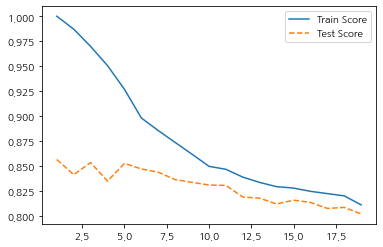

In [31]:
plt.plot(para_leaf,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_leaf,test_score,linestyle ='--', label = "Test Score")
plt.legend()
#leaf=10

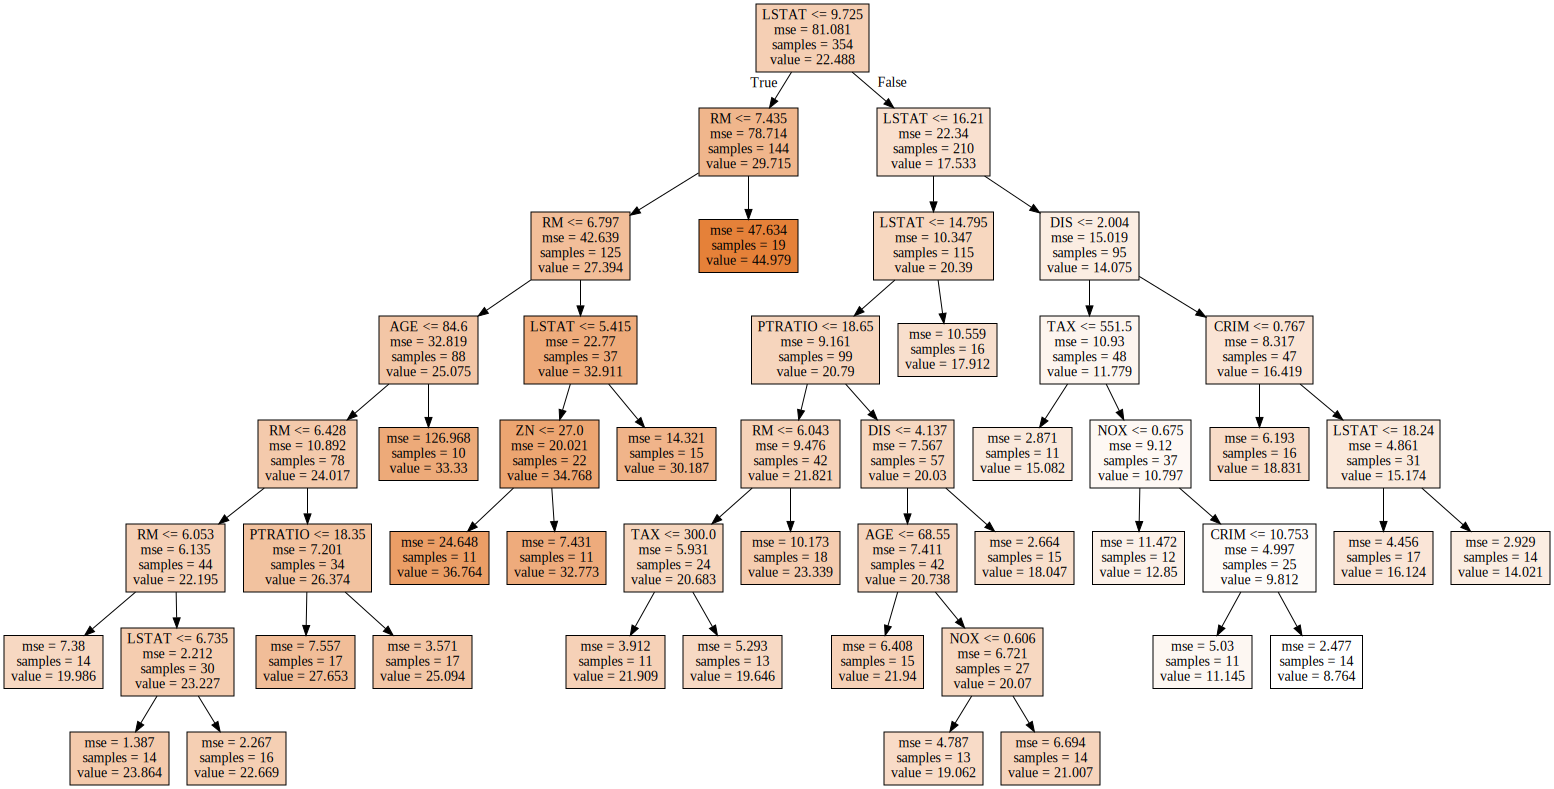

In [32]:
v_feature_name = df_test_x.columns

tree_graph = DecisionTreeRegressor(random_state = 1234 , min_samples_leaf = 10)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_leaf.dot",
               feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_leaf.dot") as f:
    dot_graph =f.read()

display(graphviz.Source(dot_graph))

In [33]:
train_score = []; test_score=[]
para_split = [n_split * 2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(min_samples_leaf=10
                                 ,random_state=1234,
                                min_samples_split=v_min_samples_split)
    
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    

    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

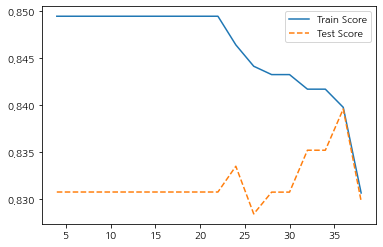

In [34]:

df_score_leaf.round(3)

plt.plot(para_split,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_split,test_score,linestyle ='--', label = "Test Score")
plt.legend()

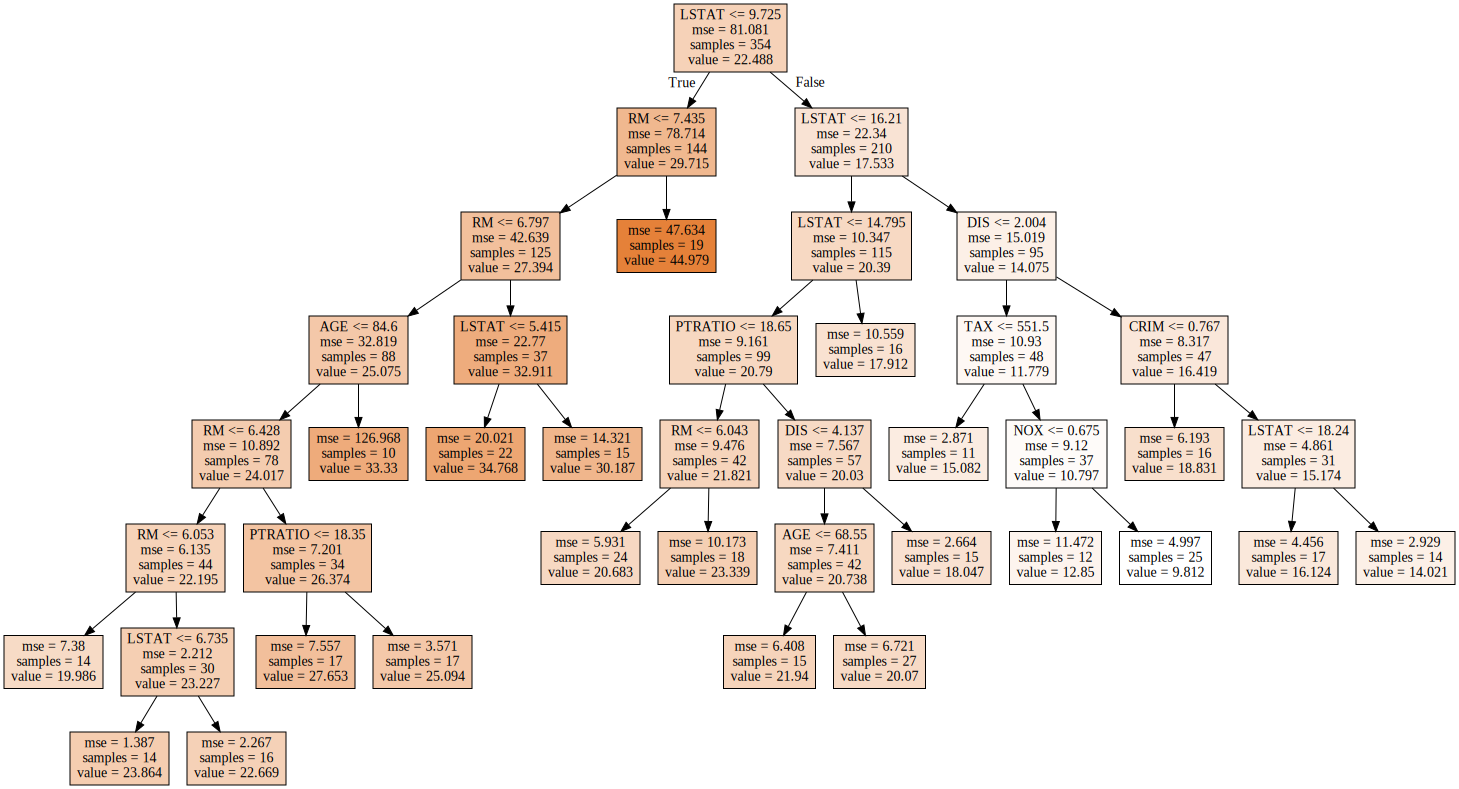

In [35]:
v_feature_name = df_test_x.columns

tree_graph = DecisionTreeRegressor(random_state = 1234 , min_samples_leaf = 10,min_samples_split=30)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_leaf.dot",
               feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_leaf.dot") as f:
    dot_graph =f.read()

display(graphviz.Source(dot_graph))

In [37]:
train_score = []; test_score=[]
para_depth = [depth  for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(min_samples_leaf=10
                                 ,random_state=1234,
                                min_samples_split=30,
                                max_depth=v_max_depth)
    
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    

    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

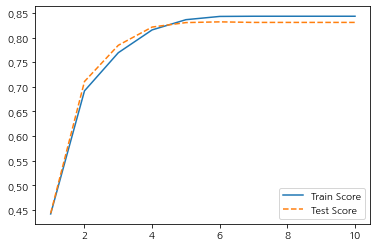

In [38]:

df_score_leaf.round(3)

plt.plot(para_depth,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_depth,test_score,linestyle ='--', label = "Test Score")
plt.legend()

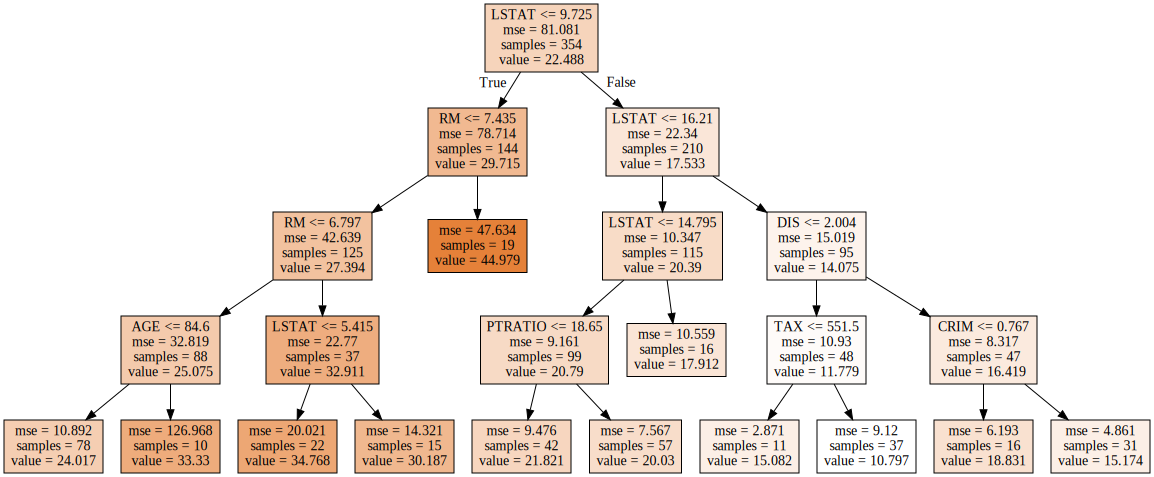

In [39]:
v_feature_name = df_test_x.columns

tree_graph = DecisionTreeRegressor(random_state = 1234 , min_samples_leaf = 10,
                                   min_samples_split=30,
                                   max_depth=4)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = "tree_leaf.dot",
               feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_leaf.dot") as f:
    dot_graph =f.read()

display(graphviz.Source(dot_graph))

In [40]:
tree_final = DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=30, max_depth=4, random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=30,
                      random_state=1234)

In [41]:
df_importance= pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"]=tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,LSTAT,0.643
5,RM,0.286
6,AGE,0.033
7,DIS,0.022
9,TAX,0.007
0,CRIM,0.006
10,PTRATIO,0.003
1,ZN,0.000
2,INDUS,0.000
3,CHAS,0.000


Text(0, 0.5, '변수')

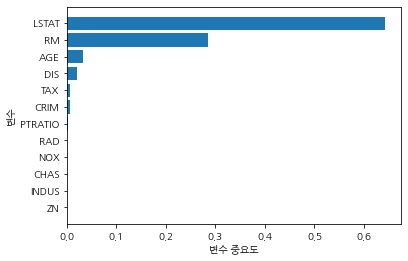

In [42]:
df_importance.sort_values("Importance", ascending =True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 랜덤포레스트 회귀 

In [44]:
df_raw_y = df_raw["MEDV"]
df_raw_x = df_raw.drop("MEDV", axis = 1, inplace = False)

In [45]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
                                                               ,test_size = 0.3, random_state = 1234)


In [46]:
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (354, 12)
train data Y size: (354,)
test data X size: (152, 12)
test data Y size: (152,)


In [49]:
rf_uncustomized = RFR(random_state=1234)
rf_uncustomized.fit(df_train_x,df_train_y)

RandomForestRegressor(random_state=1234)

In [50]:

print("Score on traing set:{:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))

print("Score on test set:{:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

Score on traing set:0.981
Score on test set:0.895


In [51]:
train_score = []; test_score=[]


para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state=1234,n_estimators = v_n_estimators)
    
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    

    
df_score_n = pd.DataFrame()
df_score_n["n_estimator"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

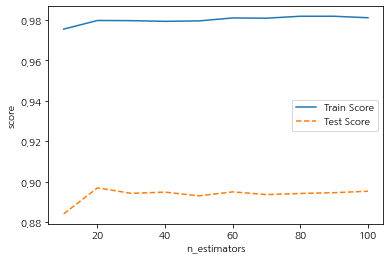

In [52]:

df_score_n.round(3)

plt.plot(para_n_tree,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_n_tree,test_score, linestyle ='--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [55]:
train_score = []; test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(random_state=1234,n_estimators = 60,
                                min_samples_leaf=v_min_samples_leaf)
    
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    

    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

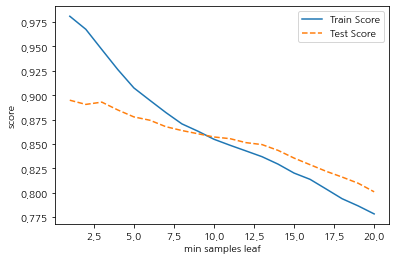

In [56]:
df_score_leaf.round(3)

plt.plot(para_leaf,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_leaf,test_score, linestyle ='--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

In [61]:
train_score = []; test_score=[]
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(random_state=1234,n_estimators = 60,
                                min_samples_leaf=10,
            min_samples_split=v_min_samples_split)
    
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    

    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

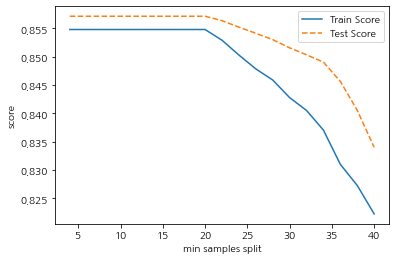

In [62]:
df_score_split.round(3)

plt.plot(para_split,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_split,test_score, linestyle ='--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

In [63]:
train_score = []; test_score=[]
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(random_state=1234,n_estimators = 60,
                                min_samples_leaf=10,
            min_samples_split=20,
            max_depth=v_max_depth)
    
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    

    
df_score_depth = pd.DataFrame()
df_score_depth["MinSamplesSplit"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

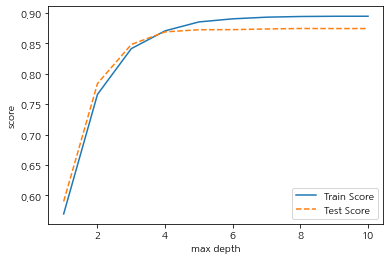

In [60]:
df_score_depth.round(3)

plt.plot(para_depth,train_score, linestyle = '-', label = "Train Score")
plt.plot(para_depth,test_score, linestyle ='--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

In [64]:
rf_final = RFR(n_estimators = 60, min_samples_leaf=10, min_samples_split=20, max_depth=4, random_state=1234)
rf_final.fit(df_train_x,df_train_y)

RandomForestRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=60, random_state=1234)

In [65]:
rf_final.fit(df_train_x,df_train_y)

print("Score on Training set:{:.3}".format(rf_final.score(df_train_x,df_train_y)))

print("Score on Test set:{:.3}".format(rf_final.score(df_test_x,df_test_y)))

Score on Training set:0.842
Score on Test set:0.855


In [66]:
v_feature_name = df_train_x.columns

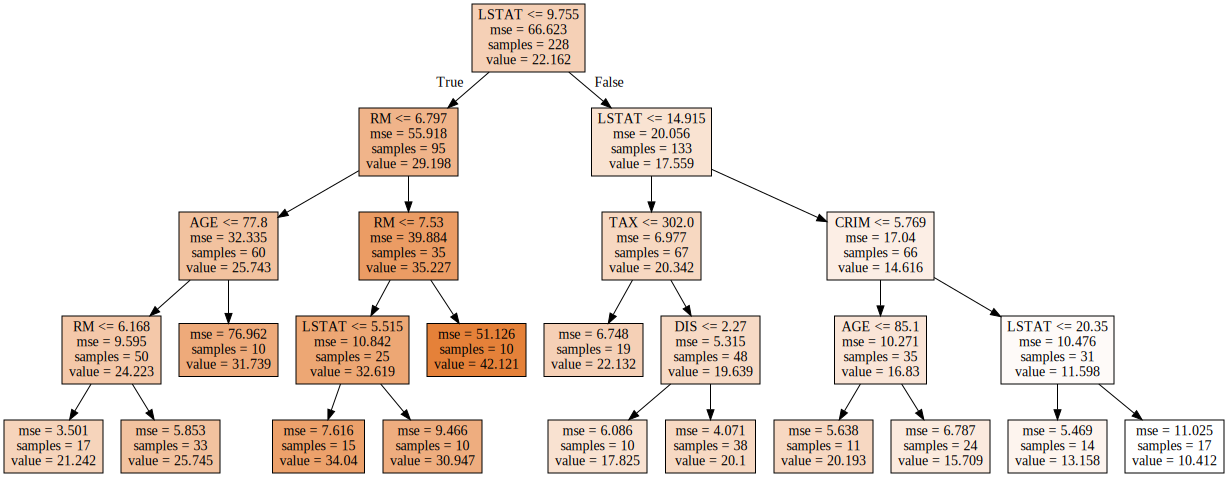

In [67]:

export_graphviz(rf_final.estimators_[0], out_file = "rf_final_0.dot",
               feature_names = v_feature_name, impurity = True, filled = True)

with open("rf_final_0.dot") as f:
    dot_graph =f.read()

display(graphviz.Source(dot_graph))

In [68]:
df_importance= pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"]=rf_final.feature_importances_


df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,LSTAT,0.554
5,RM,0.381
0,CRIM,0.018
4,NOX,0.012
6,AGE,0.010
7,DIS,0.010
9,TAX,0.006
8,RAD,0.003
10,PTRATIO,0.003
2,INDUS,0.001


Text(0, 0.5, '변수')

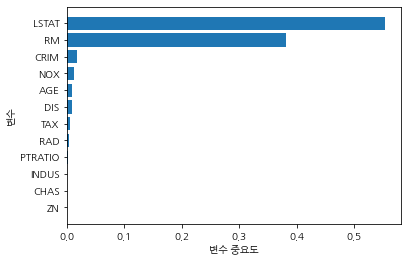

In [69]:
df_importance.sort_values("Importance", ascending =True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")